In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import mne 
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction
from torch.optim import Adam 
import torch 
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

/Users/noelkamm/eeg_llm/eeg_tf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# load data and epoch it 
raw = mne.io.read_raw_eeglab('../data/sep_uwgr_prepro.set', preload=False)
events, event_id = mne.events_from_annotations(raw)

tmin = -0.05
tmax = 0.22

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=None, preload=False)

Reading /Users/noelkamm/eeg_llm/notebooks/../data/sep_uwgr_prepro.fdt


/var/folders/hb/6djt3xvj4lj0rw_hcjlj9r940000gn/T/ipykernel_7483/2358760923.py:2: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_raw_eeglab('../data/sep_uwgr_prepro.set', preload=False)


Used Annotations descriptions: [np.str_('1')]
Not setting metadata
6038 matching events found
No baseline correction applied
0 projection items activated


In [4]:
# get epoched data and average data 
data_original = epochs.get_data()
avg_data_original = epochs.average().data

Loading data for 6038 events and 554 original time points ...
0 bad epochs dropped


In [5]:
# reshape the data according to model input 
data = np.transpose(data_original, (0, 2, 1))
avg_data = np.transpose(avg_data_original, (1, 0))

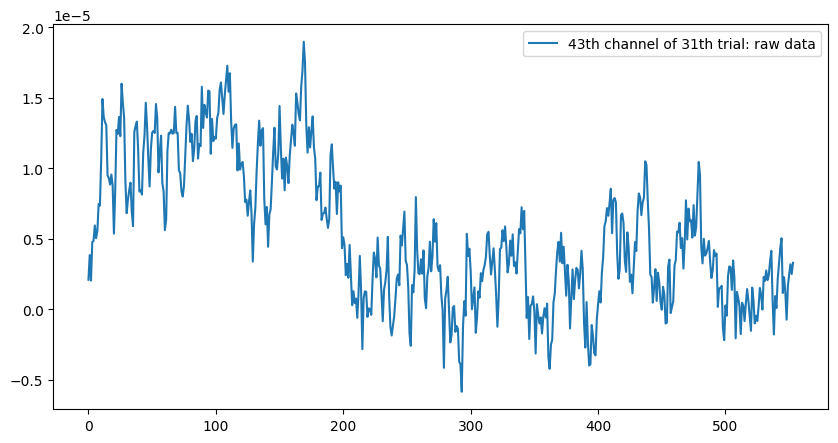

In [6]:
# plot a channel of a trial of the raw data 
tr = 30
ch = 42
plt.figure(figsize=(10, 5))
plt.plot(data[tr, :, ch], label=f"{ch+1}th channel of {tr+1}th trial: raw data")
plt.legend()
plt.show()

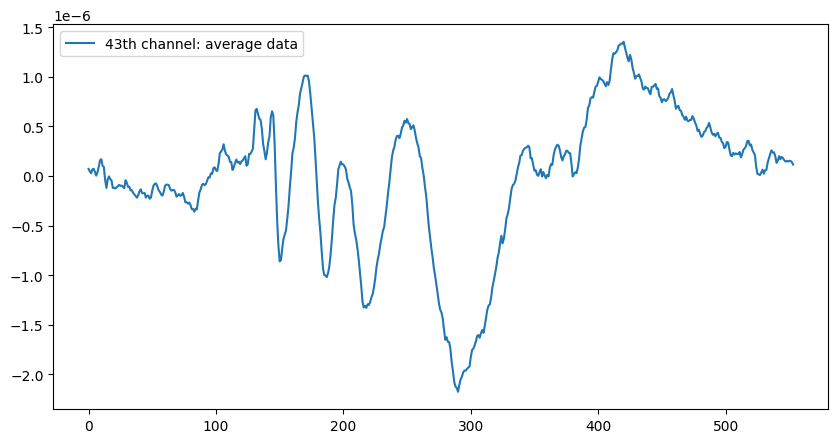

In [7]:
# plot a channel of the average data 
ch = 42
plt.figure(figsize=(10, 5))
plt.plot(avg_data[:, ch], label=f"{ch+1}th channel: average data")
plt.legend()
plt.show()

In [8]:
def split_data(data, test_size=0.2, random_state=None):
    X_train, y = train_test_split(data, test_size=test_size, random_state=random_state)
    return X_train, y

In [9]:
# split the data into training and test set 
X_train, y = split_data(data, random_state=42)

In [10]:
def create_data_loaders(X_train, X_test, batch_size=16, shuffle=True):
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    train_dataset = TensorDataset(X_train)
    test_dataset = TensorDataset(X_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader 

In [11]:
# batch the data 
train_loader, test_loader = create_data_loaders(X_train, y)

In [12]:
def split_past_future(batch, num_future_points=None):
    if len(batch.shape) == 3:
        past_values = batch[:, :-num_future_points, :]
        future_values = batch[:, -num_future_points:, :]
    else: 
        past_values = batch[:, :-num_future_points]
        future_values = batch[:, -num_future_points:]
    return past_values, future_values

In [13]:
# get raw data for one channel for testing purposes 
ch = 42
ch_data = data[:, :, ch]
ch_train, ch_test = split_data(ch_data, random_state=42)
ch_train_loader, ch_test_loader = create_data_loaders(ch_train, ch_test)

In [14]:
# define the configuration of the model 
ch_config = TimeSeriesTransformerConfig(
    prediction_length=154,  # length of the future values to predict
    context_length=399,  # length of the past values to use
    num_time_features=1, # number of time features
    encoder_layers=2,  # number of transformer layers in the encoder
    decoder_layers=2,  # number of transformer layers in the decoder
    d_model=32,  # dimension of the model
    n_heads=4,  # number of attention heads
    input_size=1, # size of the input 
    lags_sequence=[1], # sequence of lags 
    distribution_output='normal', # distribution where the output is sampled from
    )

# initialize the model 
model = TimeSeriesTransformerForPrediction(ch_config)

In [16]:
# define the prediciton lenght
num_future_points = 154
# Initialize optimizer
optim = Adam(model.parameters(), lr=1e-3)
# store the params 
params_lst = []
# Define the number of epochs 
num_epochs = 5

# iterate over all epochs 
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0 
    epoch_params = []

    # iterate over each batch 
    for batch in ch_train_loader: 
        past_values, future_values = split_past_future(batch[0], num_future_points=num_future_points)

        batch_dict = {
            "past_values": past_values,  # (batch_size, input_length, input_size)
            "future_values": future_values,  # (batch_size, prediction_length, input_size)
            "past_time_features": torch.arange(past_values.size(1)).unsqueeze(0).unsqueeze(2).float().repeat(past_values.size(0), 1, 1),  # (batch_size, seq_length, 1)
            "past_observed_mask": torch.ones_like(past_values),  # (batch_size, seq_length, input_size)
            "future_observed_mask": torch.ones_like(future_values), # (batch_size, prediciton_lenght, input_size)
            "future_time_features": torch.arange(past_values.size(1), past_values.size(1) + num_future_points).unsqueeze(0).unsqueeze(2).float().repeat(future_values.size(0), 1, 1),  # (batch_size, prediction_length, 1)
            "return_dict": True
        }

        # Forward pass
        outputs = model(
            past_values=batch_dict["past_values"],
            past_time_features=batch_dict["past_time_features"],
            past_observed_mask=batch_dict["past_observed_mask"],
            future_observed_mask=batch_dict["future_observed_mask"],
            future_values=batch_dict["future_values"],
            future_time_features=batch_dict["future_time_features"],
            return_dict=batch_dict["return_dict"]
        )

        loss = outputs.loss
        scale = outputs.scale
        loc = outputs.loc

        params = (scale * outputs.params[0] + loc, scale * outputs.params[1])
        epoch_params.append(params)

        # Backward pass
        optim.zero_grad()
        loss.backward()
        optim.step()

        total_loss += loss.item()
    params_lst.append(epoch_params)
    # params_lst.append(epoch_params)
    epoch_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/5, Loss: -10.5470
Epoch 2/5, Loss: -11.1905


KeyboardInterrupt: 

In [17]:
epoch_dict = np.array([
    [{"mu": 0, "sigma": 0}
     for _ in range(len(params_lst[0][0][0][0]))]
    for _ in range(len(params_lst))
])
num_batches = len(params_lst[0])


for i, epoch in enumerate(params_lst):

    for j, batch in enumerate(epoch): 
        mean = batch[0]
        std_dev = batch[1]

        for time_point in range(mean.size(1)):
            

            mu = mean[:, time_point].detach().numpy()
            sigma = std_dev[:, time_point].detach().numpy()

            epoch_dict[i,time_point]["mu"] += np.mean(mu)
            epoch_dict[i,time_point]["sigma"] += np.mean(sigma)
            
    for time_point in range(len(epoch_dict[i])):
        epoch_dict[i,time_point]["mu"] /= num_batches
        epoch_dict[i,time_point]["sigma"] /= num_batches

In [20]:
epoch_df = pd.DataFrame(epoch_dict.tolist())

In [42]:
ep = 4
samples = epoch_df.shape[1]
t = [i for i in range(samples)]
mu_across_samples = epoch_df.loc[ep, :].apply(lambda x: x["mu"]).values 
sigma_across_samples = epoch_df.loc[ep, :].apply(lambda x: x["sigma"]).values

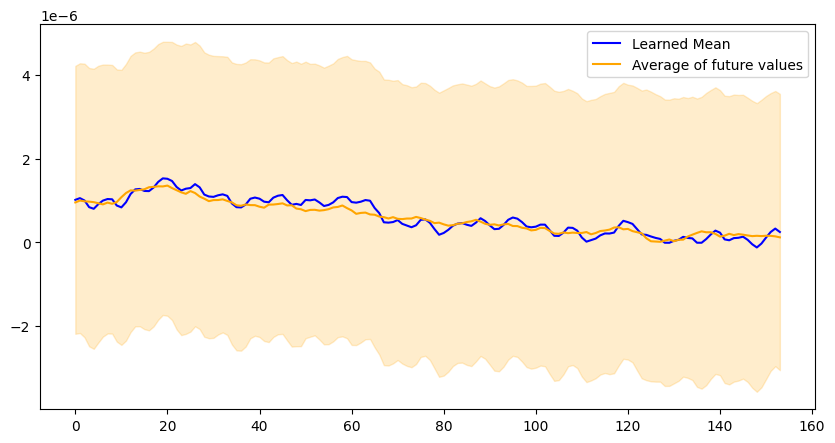

In [50]:
pl = 154
ch = 42
plt.figure(figsize=(10, 5))
plt.plot(t, mu_across_samples, label="Learned Mean", color='blue')
plt.plot(t, avg_data[-pl:, ch], label="Average of future values", color='orange')
plt.fill_between(t, 
                 [m - s for m, s in zip(mu_across_samples, sigma_across_samples)],
                 [m + s for m, s in zip(mu_across_samples, sigma_across_samples)], 
                color='orange', 
                alpha=0.2,
)

plt.legend()
plt.show()

In [47]:
# define the prediction length for testing 
prediciton_length = 154
generated_predicitons = []

# iterate over each batch 
for batch in ch_test_loader:

    past_values, future_values = split_past_future(batch[0], num_future_points=prediciton_length)

    batch = {
            "past_values": past_values,  # (batch_size, input_length, input_size)
            "future_values": future_values,  # (batch_size, prediction_length, input_size)
            "past_time_features": torch.arange(past_values.size(1)).unsqueeze(0).unsqueeze(2).float().repeat(past_values.size(0), 1, 1),  # (batch_size, seq_length, 1)
            "past_observed_mask": torch.ones_like(past_values),  # (batch_size, seq_length, input_size)
            "future_time_features": torch.arange(past_values.size(1), past_values.size(1) + num_future_points).unsqueeze(0).unsqueeze(2).float().repeat(future_values.size(0), 1, 1),  # (batch_size, prediction_length, 1)
        }
    
    # set the model to evaluation mode  
    model.eval()

    # create predicitons 
    with torch.no_grad():
        predictions=model.generate(
            past_values=batch["past_values"],
            past_time_features=batch["past_time_features"],
            future_time_features=batch["future_time_features"], 
            past_observed_mask=batch["past_observed_mask"], 
        )

    generated_batch_predictions = predictions.sequences
    if generated_batch_predictions.shape[0] == 16:
        generated_predicitons.append(generated_batch_predictions)

KeyboardInterrupt: 

In [25]:
generated_predicitons = np.array(generated_predicitons)
num_batches = generated_predicitons.shape[0]
batch_size = generated_predicitons.shape[1]
samples = generated_predicitons.shape[2]
seq_length = generated_predicitons.shape[3]

generated_predicitons = generated_predicitons.reshape(num_batches*batch_size, samples, seq_length) 

In [26]:
generated_predicitons.shape

(1200, 100, 154)

In [40]:
pred_mean  = np.mean(generated_predicitons, axis=1)
obsv_mean = np.mean(generated_predicitons, axis=0)
grand_mean = np.mean(np.mean(generated_predicitons, axis=0), axis=0)

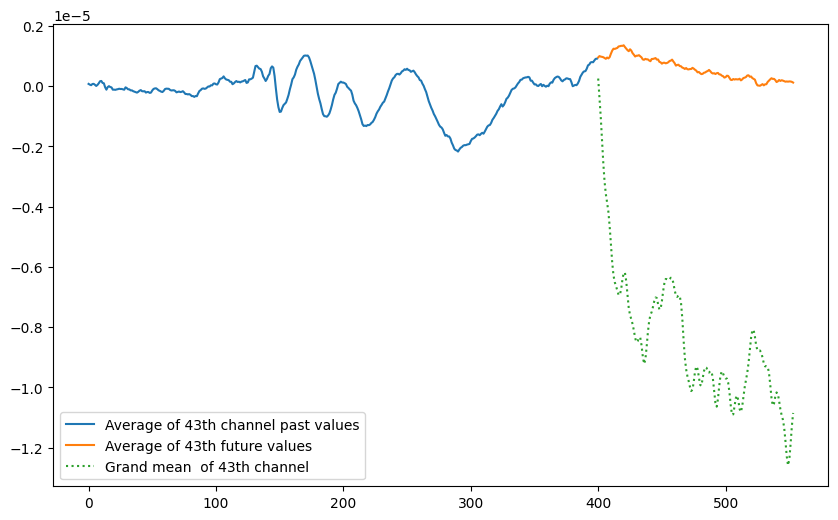

In [41]:
# define observation you want to examine 
pred = 60
pl = 154
sample = 40
ch = 42
# Plot the best predictions
plt.figure(figsize=(10, 6))

# Plot the average past values
plt.plot(np.arange(len(avg_data[:-pl])), avg_data[:-pl, ch], label=f"Average of {ch+1}th channel past values")

# Plot true future values
plt.plot(np.arange(len(avg_data[:-pl]), len(avg_data[:-pl]) + pl), avg_data[-pl:, ch], label=f"Average of {ch+1}th future values")

# Plot the mean over samples 
# plt.plot(np.arange(len(avg_data[:-pl]), len(avg_data[:-pl]) + pl), pred_mean[pred, :], label=f"Mean over samples  of {ch+1}th channel", linestyle="dotted")

# Plot the mean over observations 
# plt.plot(np.arange(len(avg_data[:-pl]), len(avg_data[:-pl]) + pl), obsv_mean[sample, :], label=f"Mean over observations  of {ch+1}th channel", linestyle="dotted")

# Plot the grand mean 
plt.plot(np.arange(len(avg_data[:-pl]), len(avg_data[:-pl]) + pl), grand_mean, label=f"Grand mean  of {ch+1}th channel", linestyle="dotted")

# plot the learned parameter 
 
plt.legend(loc='lower left')
plt.show()
